In [34]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from time import time
from tqdm import tqdm
from utils import build_db
%matplotlib inline

In [2]:
keys_path_x = '../Data/css-sdss/X-match/keys.csv'
spec_path = '../Data/features/VAE-sdss/Exp3/features/features.npy'
fats_path = '../Data/features/FATS-css/fats.csv'

ts_key = 'names'
spec_key = 'names'

filter_l = ['EA', 'EW', 'RRab', 'RRc', 'RRd', 'RS CVn']

In [3]:
dir_ = './features/'
if not os.path.exists(dir_):
    os.makedirs(dir_)

### Build db

In [4]:
db = build_db(fats_path, ts_key, spec_path, spec_key, keys_path_x, filter_l)

In [5]:
db['fats'].shape, db['vae'].shape

((2554, 54), (2554, 7))

### Select features

In [6]:
keys = np.hstack([db['fats_keys'], db['vae_keys']])
data = np.hstack([db['fats'], db['vae']])
X_df = pd.DataFrame(data, columns=keys)
y = db['labels']

In [7]:
def get_importances(X_df, y):
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(X_df, y)
    
    keys = X_df.columns
    weights = clf.feature_importances_
    importances = pd.DataFrame(np.vstack([weights, keys]).T, columns=['weight', 'feature'])
    importances = importances.sort_values('weight', ascending=False)
    importances['cum_weight'] = importances['weight'].cumsum()
    features = importances['feature']
    f = lambda i: features.iloc[:i].values
    importances['group'] = [f(i) for i in range(1, len(features)+1)]
    importances = importances.reset_index(drop=True)
    importances.head()
    
    return importances

In [8]:
importances = get_importances(X_df, y)
importances_path = dir_+'importances.npy'
importances.to_csv(importances_path)

In [9]:
def metrics_groups(X_df, y, importances):
    metrics = {}
    labels = np.unique(y)
    skf = StratifiedKFold(n_splits=10)

    fold = 0
    for train_index, test_index in skf.split(X_df.values, y):
        t0 = time()
        for i, group in importances.iterrows():
            features = group['group']
            clf = RandomForestClassifier(n_estimators=200)
            X = X_df[features].values
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf.fit(X_train, y_train)

            pred = clf.predict(X_test)
            f1 = f1_score(y_test, pred, labels=labels, average=None)
            f1 = dict(zip(labels, f1))
            acc = accuracy_score(y_test, pred)

            if not i in metrics.keys():
                metrics[i] = dict()
                metrics[i]['feature_in'] = group['feature']
                metrics[i]['feature_in_w'] = group['weight']
                metrics[i]['features'] = group['group']
                metrics[i]['features_w'] = group['cum_weight']
                metrics[i]['folds'] = {}
            metrics[i]['folds'][fold] = dict()
            metrics[i]['folds'][fold]['f1-score'] = f1
            metrics[i]['folds'][fold]['acc'] = acc
        t1 = time()
        msg = 'Fold '+str(fold)+' time: '+ str(np.round(t1-t0, decimals=2))+' s.'
        print(msg)
        fold +=1
    return metrics

In [10]:
metrics = metrics_groups(X_df, y, importances)
metrics_path = dir_+'metrics.npy'
np.save(metrics_path, metrics)

/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 0 time: 86.81 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 1 time: 88.92 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 2 time: 88.93 s.
Fold 3 time: 88.04 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 4 time: 87.14 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 5 time: 87.34 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 6 time: 87.08 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 7 time: 88.31 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 8 time: 86.36 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Javiera/anaco

Fold 9 time: 86.12 s.


/Users/Javiera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Metrics

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

dir_ = './features/'
metrics_path = dir_+'metrics.npy'
metrics = np.load(metrics_path).item()
importances_path = dir_+'importances.npy'
importances = pd.read_csv(importances_path)
importances = importances.drop(importances.columns[0], axis=1)
db = np.load('db.npy').item()
y = db['labels']

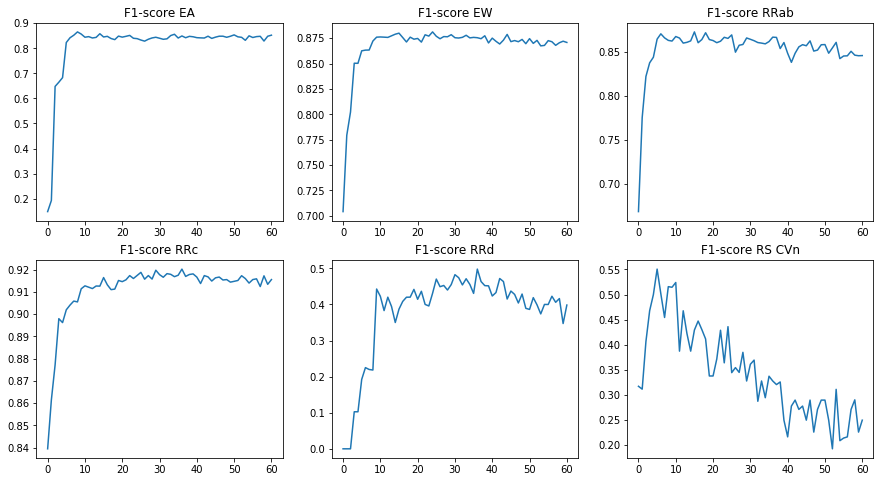

In [10]:
labels = np.unique(y)
f1_all = {}

for cls in labels:
    f1_cls = {}
    for k in metrics.keys():
        group = metrics[k]
        f1 = [group['folds'][fold]['f1-score'][cls] for fold in range(10)]
        f1 = np.mean(f1)
        f1_cls[k] = f1
    f1_all[cls] = f1_cls

plt.figure(figsize=(15,8))
for i, cls in enumerate(list(f1_all.keys())):
    plt.subplot(2,3,i+1)
    plt.plot(f1_all[cls].keys(), f1_all[cls].values())
    plt.title('F1-score '+cls)
plt.show()

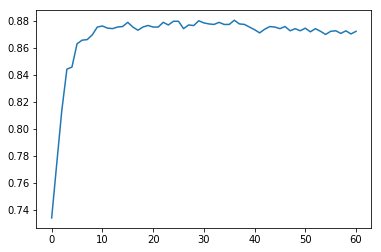

In [11]:
for k in metrics.keys():
    group = metrics[k]
    acc_folds = [group['folds'][fold]['acc'] for fold in range(10)]
    metrics[k]['acc_mean'] = np.mean(acc_folds)

acc_all = [metrics[k]['acc_mean'] for k in metrics.keys()]
plt.plot(metrics.keys(), acc_all)

In [12]:
min(acc_all), max(acc_all)

(0.7339147321152317, 0.8806171699920584)

In [13]:
acc_perc = (acc_all-min(acc_all))/(max(acc_all)-min(acc_all))
for i, k in enumerate(metrics.keys()):
    metrics[k]['acc_perc'] = acc_perc[i]

In [14]:
features = [metrics[k]['features'] for k in metrics.keys()]
feature_in = [metrics[k]['feature_in'] for k in metrics.keys()]
weight = [metrics[k]['feature_in_w'] for k in metrics.keys()]
acc_mean = [metrics[k]['acc_mean'] for k in metrics.keys()]
acc_perc = [metrics[k]['acc_perc'] for k in metrics.keys()]
data = np.vstack([features, feature_in, weight, acc_mean, acc_perc]).T
metrics_df = pd.DataFrame(data, columns=['features', 'feature_in', 'weight', 'acc_mean', 'acc_perc'])
metrics_df

,features,feature_in,weight,acc_mean,acc_perc
0,[PeriodLS],PeriodLS,0.143094,0.733915,0
1,"[PeriodLS, Freq1_harmonics_amplitude_0]",Freq1_harmonics_amplitude_0,0.0592174,0.774161,0.274338
2,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",MedianAbsDev,0.0477548,0.81373,0.544059
3,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",spec2,0.0463957,0.844309,0.752504
4,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",Q31,0.0430751,0.845891,0.763291
5,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",FluxPercentileRatioMid35,0.0328388,0.863116,0.880706
6,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",FluxPercentileRatioMid50,0.0321198,0.865831,0.899208
7,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",Freq1_harmonics_amplitude_1,0.0295254,0.86624,0.901997
8,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",spec5,0.0288499,0.869756,0.925962
9,"[PeriodLS, Freq1_harmonics_amplitude_0, Median...",Freq2_harmonics_amplitude_0,0.0250333,0.875553,0.965477


In [33]:
min(metrics_df['acc_mean']), max(metrics_df['acc_mean'])

(0.7339147321152317, 0.8806171699920584)

In [15]:
sel_features = metrics_df.iloc[8]['features']
np.save(dir_+'features.npy', sel_features)

In [29]:
sel_features = np.load(dir_+'features.npy')
s_idx = np.array([name in db['vae_keys'] for name in sel_features])
s_small = list(sel_features[s_idx])
ts_small = list(sel_features[~s_idx])
s_gini = importances.set_index('feature').loc[s_small]['weight'].sum()
ts_gini = importances.set_index('feature').loc[ts_small]['weight'].sum()
s_small, s_gini, ts_small, ts_gini

(['spec2', 'spec5'],
 0.07524553857919092,
 ['PeriodLS',
  'Freq1_harmonics_amplitude_0',
  'MedianAbsDev',
  'Q31',
  'FluxPercentileRatioMid35',
  'FluxPercentileRatioMid50',
  'Freq1_harmonics_amplitude_1'],
 0.38762557263658204)

### Add selected features to db

In [35]:
sel_features = np.load(dir_+'features.npy')
s_idx = np.array([name in db['vae_keys'] for name in sel_features])
s_small = list(sel_features[s_idx])
ts_small = list(sel_features[~s_idx])

config = {
    'spectra features': s_small,
    'FATS keys': ts_small
}
with open('config.json', 'w+') as f:
    json.dump(config, f)

config

{'spectra features': ['spec2', 'spec5'],
 'FATS keys': ['PeriodLS',
  'Freq1_harmonics_amplitude_0',
  'MedianAbsDev',
  'Q31',
  'FluxPercentileRatioMid35',
  'FluxPercentileRatioMid50',
  'Freq1_harmonics_amplitude_1']}

In [36]:
keep = np.isin(db['fats_keys'], ts_small)
db['ts_features'] = db['fats'].T[keep].T

keep = np.isin(db['vae_keys'], s_small)
db['spec_features'] = db['vae'].T[keep].T

{'EA': 148, 'EW': 749, 'RRab': 343, 'RRc': 1193, 'RRd': 78, 'RS CVn': 43}
Total number of entries: 2554


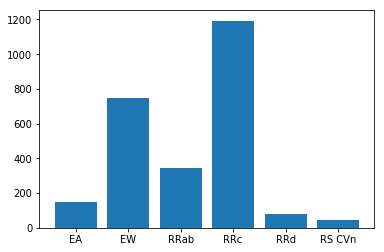

In [37]:
vals, counts = np.unique(db['labels'], return_counts=True)
print(dict(zip(vals, counts)))
print('Total number of entries:', db['labels'].shape[0])
plt.bar(vals, counts)
plt.show()

In [38]:
np.save('db.npy', db)